In [40]:
import os

import torch
import torchvision

import torchmetrics

from torchinfo import summary

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

import data_setup, model_builder, engine, utils

---

# Data

In [41]:
# Initializing a directory for the data
data_path = Path('./data/')

if not data_path.is_dir():
    os.mkdir(data_path)

In [42]:
# Getting the data from torch
train_data = torchvision.datasets.FashionMNIST(root=data_path,
                                               train=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               download=True)

test_data = torchvision.datasets.FashionMNIST(root=data_path,
                                              train=False,
                                              transform=torchvision.transforms.ToTensor(),
                                              download=True)

In [43]:
# List of all the class names
class_names = train_data.classes

for i, name in enumerate(class_names):
    print(f"Index: {i}")
    print(f"Label: {name}")
    print()

Index: 0
Label: T-shirt/top

Index: 1
Label: Trouser

Index: 2
Label: Pullover

Index: 3
Label: Dress

Index: 4
Label: Coat

Index: 5
Label: Sandal

Index: 6
Label: Shirt

Index: 7
Label: Sneaker

Index: 8
Label: Bag

Index: 9
Label: Ankle boot



In [44]:
# Gathering details about the downloaded image data
img, label = train_data[0]

print(f"Image Shape : {img.shape}")
print(f"\nNumber of Inputs for Dense model: {img.shape[1] * img.shape[2]}")

Image Shape : torch.Size([1, 28, 28])

Number of Inputs for Dense model: 784


In [45]:
# Getting a list with number of datapoints for each class
label_list = [y for _, y in train_data]

label_list = pd.Series(label_list)

print(label_list.value_counts().sort_index())

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


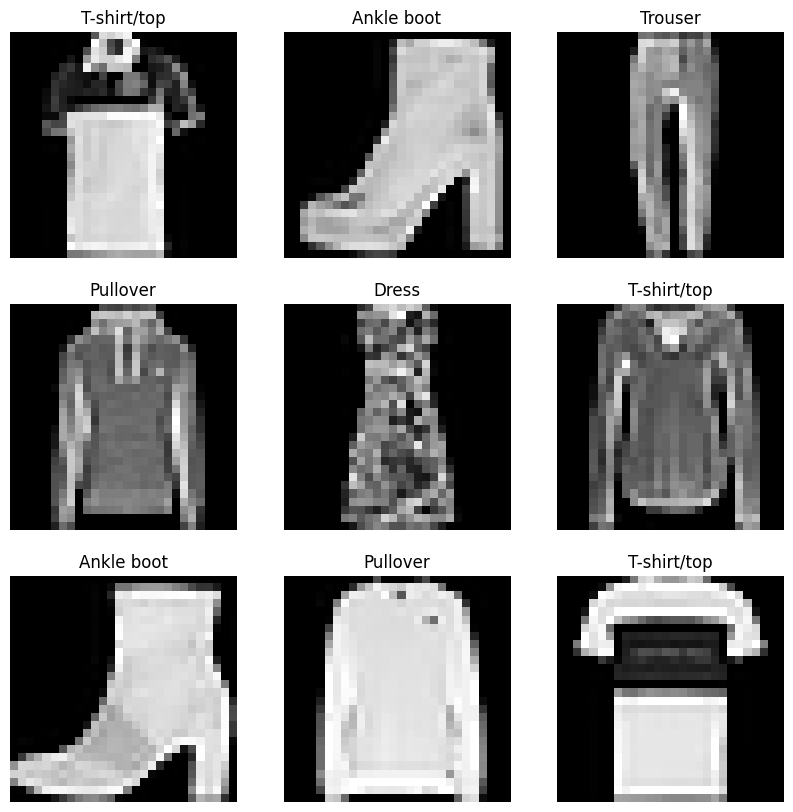

In [46]:
# Visualizing random data samples
utils.random_data_visual(dataset=train_data, 
                         class_names=class_names)

In [47]:
# Loading the datasets to the data loader
batch_size = 32
num_workers = int(os.cpu_count()/2)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=batch_size * 2,
                              shuffle=True,
                              num_workers=num_workers)

Details:
- Image dimension---: 28 * 28
- Image color-------: Grayscale
- Image Labels------: Balanced

- No data augmentation will be done as most of the data follows a similar pattern. 
- This is to reduce the complexity of the project.
- The custom data that will be fed to the model at the end of the experimentation will also follow a similar input structure.

---

# Model

- Looking the summaries of the model to make sure there are similar amount of parameters for fairness.

---

- Choosing 16 hidden units for linear, non-linear models and 15 for the convolutional model.
- This is to choose almost similar number of parameters for each model. ~13,000

In [48]:
# Initializing the models to view the summaries of the model
model_linear = model_builder.LinearFmnist(input_units=28 * 28,
                                          output_units=10,
                                          hidden_units=16)

model_non_linear = model_builder.NonLinearFmnist(input_units=28 * 28,
                                                 output_units=10,
                                                 hidden_units=16)

model_convolution = model_builder.ConvolutionFmnist(in_channels=1,
                                                    out_features=10,
                                                    hidden_channels=15,
                                                    image_height=28,
                                                    image_width=28)

In [49]:
# Input size
input_size = (1, 1, 28, 28)

In [50]:
summary(model_linear, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
LinearFmnist                             [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 16]                   12,560
│    └─Linear: 2-3                       [1, 16]                   272
│    └─Linear: 2-4                       [1, 16]                   272
│    └─Linear: 2-5                       [1, 10]                   170
Total params: 13,274
Trainable params: 13,274
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.06

In [51]:
summary(model_non_linear, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
NonLinearFmnist                          [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 16]                   12,560
│    └─ReLU: 2-3                         [1, 16]                   --
│    └─Linear: 2-4                       [1, 16]                   272
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Linear: 2-6                       [1, 16]                   272
│    └─Sigmoid: 2-7                      [1, 16]                   --
│    └─Linear: 2-8                       [1, 10]                   170
Total params: 13,274
Trainable params: 13,274
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB)

In [52]:
summary(model_convolution, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionFmnist                        [1, 10]                   --
├─Sequential: 1-1                        [1, 15, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 15, 28, 28]           150
│    └─ReLU: 2-2                         [1, 15, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 15, 28, 28]           2,040
│    └─ReLU: 2-4                         [1, 15, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 15, 14, 14]           --
├─Sequential: 1-2                        [1, 15, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 15, 14, 14]           2,040
│    └─ReLU: 2-7                         [1, 15, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 15, 14, 14]           2,040
│    └─ReLU: 2-9                         [1, 15, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 15, 7, 7]             --
├─Seq